# Solve surface volatiles according to outgassing+chemistry

In [1]:
import sys
sys.path.append("..")
from calliope.surface_gases import *
from calliope.constants import R_earth, const_G, M_earth

from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

### Set up initial options dict

In [2]:
OPTIONS = {}

OPTIONS['Phi_global'] = 1.0
OPTIONS['T_magma'] = 2500.0

OPTIONS['radius'] = R_earth * 1.875
OPTIONS['mass']   = M_earth * 7.99
OPTIONS['gravity'] = const_G * OPTIONS['mass'] / (OPTIONS['radius']**2)
OPTIONS['hydrogen_earth_oceans'] = 8.0
OPTIONS['CH_ratio'] = 1.0
OPTIONS['fO2_shift_IW'] = 0.0
OPTIONS['nitrogen_ppmw'] = 4.0
OPTIONS['sulfur_ppmw'] = 300.0
OPTIONS['planet_coresize'] = 0.5

solvevol_vols = ['H2O', 'CO2', 'N2', 'H2', 'CO', 'CH4', 'S2', 'SO2']
for v in solvevol_vols:
    OPTIONS[v+"_included"] = 0
    OPTIONS[v+"_initial_bar"] = 0.0

OPTIONS["H2O_included"] = 1
OPTIONS["CO2_included"] = 1
OPTIONS["N2_included"]  = 1
OPTIONS["S2_included"]  = 1

OPTIONS["H2_included"]  = 1
OPTIONS["CO_included"]  = 1
OPTIONS["CH4_included"] = 1
OPTIONS["SO2_included"] = 1

# OPTIONS["H2O_initial_bar"] = 1.0
# OPTIONS["CO2_initial_bar"] = 0.0
# OPTIONS["N2_initial_bar"]  = 0.0

print("Gravity = %.3f m.s-2" % OPTIONS["gravity"])



Gravity = 22.569 m.s-2


### Calculate total amount of each element in the system

In [3]:
OPTIONS["M_mantle"] = CalculateMantleMass(OPTIONS["radius"], OPTIONS["mass"], OPTIONS["planet_coresize"])
BACKUP_options = deepcopy(OPTIONS)

In [4]:
solvevol_target = get_target_from_params(OPTIONS)
# solvevol_target = get_target_from_pressures(OPTIONS)

print("Targets:")
print(solvevol_target)

Targets:
{'H': 1.24e+21, 'C': 1.24e+21, 'N': 1.53050887657802e+20, 'S': 1.147881657433515e+22}


### Solve for equilibrium atmospheric partial pressures, etc.

In [5]:
p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)

print(p_d)

p_bar = {}
for v in volatile_species:
    p_bar[v] = p_d[v+"_bar"]

mubar = 0.0
ptot = 0.0
print("Partial pressures")
for v in solvevol_vols:
    print("    %s : %.3f bar"%(v, p_bar[v]))
    ptot += p_bar[v]
    mubar += p_bar[v]*molar_mass[v]
mubar /= ptot

print("mubar =",mubar)
print("ptot = %.3f bar"%ptot)

m_d = {}
for v in solvevol_vols:
    m_d[v] = p_bar[v]*1.0e5 * 4 * 3.14 * (molar_mass[v]/mubar) * OPTIONS["radius"]**2.0 / OPTIONS["gravity"]

# print(solvevol_atmosphere_mass(p_bar, OPTIONS))

print(" ")
print(m_d)

H_kg = (2*m_d["H2O"]/molar_mass["H2O"] + 2*m_d["H2"]/molar_mass["H2"] + 4*m_d["CH4"]/molar_mass["CH4"]) *molar_mass['H']
C_kg = (m_d["CO2"]/molar_mass["CO2"] + m_d["CO"]/molar_mass["CO"] + m_d["CH4"]/molar_mass["CH4"]) * molar_mass['C']
N_kg = m_d["N2"]
S_kg = m_d["S2"]

print(H_kg, C_kg, N_kg, S_kg)


{'M_atm': np.float64(2.096612941461928e+21), 'P_surf': np.float64(266.8501535794383), 'H2O_bar': np.float64(0.3051955948716073), 'H2O_kg_atm': np.float64(1.4862048183131968e+18), 'H2O_kg_liquid': np.float64(1.1076340010140471e+22), 'H2O_kg_solid': 0.0, 'H2O_kg_total': np.float64(1.1077826214958784e+22), 'CO2_bar': np.float64(18.801396521466792), 'CO2_kg_atm': np.float64(2.236664604454997e+20), 'CO2_kg_liquid': np.float64(3.279967127744856e+20), 'CO2_kg_solid': 0.0, 'CO2_kg_total': np.float64(5.5166317321998526e+20), 'H2_bar': np.float64(0.6162129729178871), 'H2_kg_atm': np.float64(3.357800588961577e+17), 'H2_kg_liquid': 0.0, 'H2_kg_solid': 0.0, 'H2_kg_total': np.float64(3.357800588961577e+17), 'CH4_bar': np.float64(8.405554978557533e-07), 'CH4_kg_atm': np.float64(3644434462280.5327), 'CH4_kg_liquid': np.float64(445053082736.94196), 'CH4_kg_solid': 0.0, 'CH4_kg_total': np.float64(4089487545017.4746), 'CO_bar': np.float64(230.610101576547), 'CO_kg_atm': np.float64(1.746026470808342e+21),

/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:305: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:249: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:117: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent


### Check results

In [6]:
H_mol = H_kg / (1.0e-3)
H_oc  = H_mol / (7.69e22 * 2.0)

print("[H] atm = %.4f" % H_oc)
print("C/H atm = %.4f" % (C_kg/H_kg))

[H] atm = 0.0033
C/H atm = 1612.6944


### Parameter sweep demo

/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:222: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:222: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:237: RuntimeWarning: overflow encountered in exp
  ppmw = p*np.exp(4.93 - (0.000193 * p_total))
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:419: RuntimeWarning: overflow encountered in scalar multiply
  mass_int_d['N2'] = prefactor*ppmw_N2


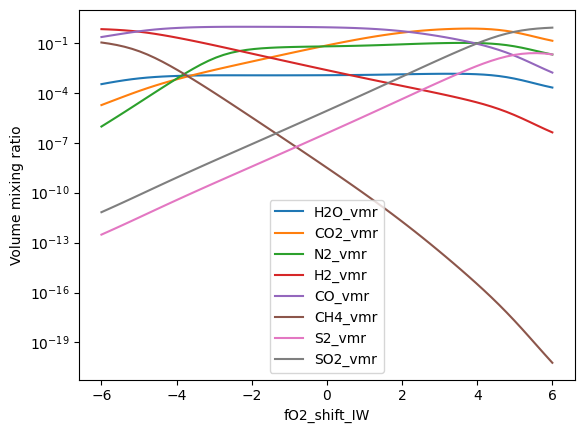

In [7]:
plt.close("all")

# parameters
x_arr = np.linspace(-6, 6, 60)
x_key = "fO2_shift_IW"
y_keys = [v+"_vmr" for v in solvevol_vols]
y_keys.extend([v+"_bar" for v in solvevol_vols])

# run model
y_out = {}
for y in y_keys:
    y_out[y] = []
for x in x_arr:
    OPTIONS = deepcopy(BACKUP_options)
    OPTIONS[x_key] = x
    solvevol_target = get_target_from_params(OPTIONS)
    p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)
    for y in y_keys:
        y_out[y].append(p_d[y])


# plot data
fig,ax = plt.subplots(1,1)

for y in y_keys:
    if "_vmr" in y:
        ax.plot(x_arr, y_out[y], label=y)
ax.set(xlabel=x_key, ylabel="Volume mixing ratio")
ax.legend()
ax.set_yscale("log")

plt.show()


# write to csv
M = []
header = x_key
M.append(x_arr)
for y in y_keys:
    M.append(y_out[y])
    header += " "+y
M = np.array(M).T
np.savetxt("nogit_solvevol.csv", M, fmt="%.4e", header=header, comments="")